In [20]:
from ais_dataloader import *
from gp_kernel_ship_classification_dataset import *
from gp_kernel_ship_classification_trainer import *
from gp_kernel_ship_classification_network import *

import time
import gc
import torch
import gpytorch
from torch.profiler import profile, record_function, ProfilerActivity
import ipywidgets as widgets
from IPython.display import display
from plotting_utils import *
from state_space_kernel import *

from multioutput_state_space_gp import *
from state_space_kernel import *
from plotting_utils import *


%load_ext autoreload
%autoreload 2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")  # Force CPU for debugging
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


## Load Data

In [21]:
date_range = pd.date_range(start='2024-01-01', end='2024-01-01', freq='D')
gp_regression_dataset = AISTrajectoryRegressionDataset(date_range, device)


Loading cached dataframe from data/processed/processed_AIS_df_2024_01_01_2024_01_01.pkl


Scaling trajectories for each MMSI: 100%|██████████| 3453/3453 [00:01<00:00, 2263.02it/s]


===== Dataset Statistics =====
Total number of AIS messages: 2128288
Number of unique MMSIs: 3453
Date range: 2024-01-01 00:00:00 to 2024-01-01 23:59:59


## Fit GP Models

In [22]:
# num_trajectories = len(gp_regression_dataset)
num_trajectories = 1
models = {}
likelihoods = {}
losses = {}

session_id = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

for idx in range(num_trajectories):
    # mmsi, times, state_trajectory = gp_regression_dataset[idx]
    mmsi, times, state_trajectory = gp_regression_dataset[3]
    print(f"\nFitting GP for trajectory {idx+1}/{num_trajectories} for MMSI {mmsi}")
    
    times = times[:15]
    print(f"Times: {times}")
    state_trajectory = state_trajectory[:15, :]
    
    
    print(f"Times shape: {times.shape}, State trajectory shape: {state_trajectory.shape}")
    times_tensor = times.detach().to(device)


    X_indices = torch.arange(len(times), device=device).unsqueeze(1)
    
    Y = state_trajectory.detach().to(device) # Targets are shape [time_steps, n_states]
    num_tasks = Y.shape[1]

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).to(device)
    
    # GP model with state space kernel
    try:
        
        model = StateSpaceGPModel(X_indices, Y, likelihood, timesteps=times_tensor, num_tasks=num_tasks).to(device)
        print("Model created successfully!")
        
        # Train with jitter for numerical stability
        with gpytorch.settings.cholesky_jitter(1e-1):
            loss, model, likelihood = train_model(model, likelihood, X_indices, Y, num_epochs=5, lr=0.1, mmsi=mmsi, session_id=session_id)
                    
        print(f"Loss: {loss.item()}")
        models[mmsi] = model
        likelihoods[mmsi] = likelihood
        losses[mmsi] = loss.item()
    except Exception as e:
        print(f"Error creating model: {e}")
        import traceback
        traceback.print_exc()


Fitting GP for trajectory 1/1 for MMSI 205717000
Times: tensor([-1.4139, -1.3393, -1.3360, -1.3079, -1.3015, -1.2540, -1.2433, -1.2397,
        -1.2367, -1.2320, -1.2275, -1.2239, -1.2207, -1.2170, -1.2124],
       device='cuda:0')
Times shape: torch.Size([15]), State trajectory shape: torch.Size([15, 6])
Model created successfully!


GP Training Progress: 100%|██████████| 5/5 [00:17<00:00,  3.51s/it]

Loss: 2.4319088459014893


## Fit Trajectories in Parallel

In [ ]:
import concurrent.futures
from functools import partial

num_trajectories = 5
models = {}
likelihoods = {}
losses = {}

# Create a session ID for grouping in TensorBoard
session_id = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

def process_trajectory(idx, dataset, device, session_id):
    mmsi, times, state_trajectory = dataset[idx]
    print(f"\nFitting GP for trajectory {idx+1}/{len(dataset)} for MMSI {mmsi}")
    
    # times = times[:100]
    # state_trajectory = state_trajectory[:100, :]
    
    times_tensor = times.detach().to(device)
    X_indices = torch.arange(len(times), device=device).unsqueeze(1)
    Y = state_trajectory.detach().to(device)
    num_tasks = Y.shape[1]
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks).to(device)
    
    try:
        model = StateSpaceGPModel(X_indices, Y, likelihood, timesteps=times_tensor, num_tasks=num_tasks).to(device)
        
        with gpytorch.settings.cholesky_jitter(1e-3):
            loss, model, likelihood = train_model(model, likelihood, X_indices, Y, 
                                                num_epochs=1, lr=0.2, mmsi=mmsi, 
                                                session_id=session_id)
        
        return mmsi, model, likelihood, loss.item()
    except Exception as e:
        print(f"Error processing trajectory {idx} (MMSI {mmsi}): {e}")
        return mmsi, None, None, float('inf')  # Return something to avoid breaking the loop

# Create a partial function with fixed arguments
process_fn = partial(process_trajectory, 
                    dataset=gp_regression_dataset, 
                    device=device,
                    session_id=session_id)

# Run in parallel
models = {}
likelihoods = {}
losses = {}

# Use number of workers based on CPU cores, but not too many to avoid memory issues
max_workers = min(4, os.cpu_count())
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Process all trajectories in parallel
    trajectory_indices = list(range(num_trajectories))
    results = list(executor.map(process_fn, trajectory_indices))
    
    # Collect results (only store successful ones)
    for mmsi, model, likelihood, loss in results:
        if model is not None:
            models[mmsi] = model
            likelihoods[mmsi] = likelihood
            losses[mmsi] = loss

print(f"Successfully processed {len(models)}/{num_trajectories} trajectories")


Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]




Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 0 (MMSI 3660489): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor

Fitting GP for trajectory 5/3453 for MMSI 209156000



Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 0 (MMSI 3660489): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor

Fitting GP for trajectory 5/3453 for MMSI 209156000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]




Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 0 (MMSI 3660489): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor

Fitting GP for trajectory 5/3453 for MMSI 209156000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 1 (MMSI 203661016): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor



Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 0 (MMSI 3660489): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor

Fitting GP for trajectory 5/3453 for MMSI 209156000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 1 (MMSI 203661016): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]




Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 0 (MMSI 3660489): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor

Fitting GP for trajectory 5/3453 for MMSI 209156000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 1 (MMSI 203661016): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 3 (MMSI 205717000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor



Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 0 (MMSI 3660489): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor

Fitting GP for trajectory 5/3453 for MMSI 209156000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 1 (MMSI 203661016): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 3 (MMSI 205717000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]




Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 0 (MMSI 3660489): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor

Fitting GP for trajectory 5/3453 for MMSI 209156000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 1 (MMSI 203661016): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 3 (MMSI 205717000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 2 (MMSI 205691000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor



Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 0 (MMSI 3660489): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor

Fitting GP for trajectory 5/3453 for MMSI 209156000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 1 (MMSI 203661016): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 3 (MMSI 205717000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 2 (MMSI 205691000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]


Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 0 (MMSI 3660489): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor

Fitting GP for trajectory 5/3453 for MMSI 209156000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 1 (MMSI 203661016): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 3 (MMSI 205717000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 2 (MMSI 205691000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Error processing trajectory 4 (MMSI 209156000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor



Fitting GP for trajectory 1/3453 for MMSI 3660489

Fitting GP for trajectory 2/3453 for MMSI 203661016

Fitting GP for trajectory 3/3453 for MMSI 205691000

Fitting GP for trajectory 4/3453 for MMSI 205717000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 0 (MMSI 3660489): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor

Fitting GP for trajectory 5/3453 for MMSI 209156000


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 1 (MMSI 203661016): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 3 (MMSI 205717000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]



Error processing trajectory 2 (MMSI 205691000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


GP Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]

Error processing trajectory 4 (MMSI 209156000): _matrix_mult_impl() Expected a value of type 'Tensor (inferred)' for argument 'Al_T' but instead found type 'float'.
Inferred 'Al_T' to be of type 'Tensor' because it was not annotated with an explicit type.
Position: 3
Value: 1.0
Declaration: _matrix_mult_impl(Tensor self, Tensor Ak, Tensor Bi_BiT, Tensor Al_T, Tensor ku) -> Tensor
Cast error details: Unable to cast 1.0 to Tensor


KeyboardInterrupt: 

### Assess a single model kernel

In [23]:
model = next(iter(models.values()))  # Get one of the models for demonstration
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.tolist()}')
    
print()
# print(model.covar_module.data_covar_module.kernels[0].lengthscale.item())

Parameter name: likelihood.raw_task_noises                 value = [-0.0500163808465004, -0.05000694468617439, -0.050007060170173645, -0.05000057816505432, -0.05002611503005028, -0.050008244812488556]
Parameter name: likelihood.raw_noise                       value = [-0.05001334846019745]
Parameter name: mean_module.base_means.0.raw_constant      value = -0.050014328211545944
Parameter name: mean_module.base_means.1.raw_constant      value = -0.0480039082467556
Parameter name: mean_module.base_means.2.raw_constant      value = -0.04996304586529732
Parameter name: mean_module.base_means.3.raw_constant      value = 0.05002221092581749
Parameter name: mean_module.base_means.4.raw_constant      value = 0.049979910254478455
Parameter name: mean_module.base_means.5.raw_constant      value = 0.049248844385147095
Parameter name: base_kernel.raw_m                          value = 11.512925148010254
Parameter name: base_kernel.raw_I                          value = 6.907755374908447
Parameter n

### Plot GP Solution

In [24]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from plotting_utils import *


def plot_for_mmsi(selected_mmsi):
    clear_output(wait=True)
    model = models[selected_mmsi]
    likelihood = likelihoods[selected_mmsi]
    # Get the corresponding data for this MMSI
    times, state_trajectory = None, None
    for entry in gp_regression_dataset:
        if entry[0] == selected_mmsi:
            _, times, state_trajectory = entry
            break
    if times is None:
        print("No data for MMSI:", selected_mmsi)
        return

    train_X = times.clone().detach().unsqueeze(1).cpu()
    train_Y = state_trajectory.clone().detach().cpu()
    test_X = torch.linspace(times.min(), times.max(), 5).unsqueeze(1).to(device)
    test_Y = eval_model(model, likelihood, test_X)

    plot_gp(train_X, train_Y, test_X, test_Y)
    plot_single_ship_path(selected_mmsi, times, state_trajectory.cpu().numpy())

    
mmsi_dropdown = widgets.Dropdown(
    options=list(models.keys()),
    description='MMSI:',
    disabled=False,
)

widgets.interact(plot_for_mmsi, selected_mmsi=mmsi_dropdown)
    
    
    

interactive(children=(Dropdown(description='MMSI:', options=(205717000,), value=205717000), Output()), _dom_cl…

<function __main__.plot_for_mmsi(selected_mmsi)>

In [ ]:
print(pd.unique(gp_regression_dataset.df['MMSI'].values))
gp_regression_dataset.get_vessel_group_by_mmsi(3660489)

[367669550 367118980 636018568 ... 367619000 309108000 368926390]


'Other'

## Create the kernel param to ship mmsi dataset


In [ ]:
kernel_classification_dataset = GPKernelShipClassificationDataset(gp_regression_dataset, models, device, scalers_by_mmsi=gp_regression_dataset.scalers_by_mmsi)
unique_group_ids = kernel_classification_dataset.get_unique_group_ids()

train_classification_dataset, test_classification_dataset = torch.utils.data.random_split(kernel_classification_dataset, [0.8, 0.2])
train_loader = torch.utils.data.DataLoader(train_classification_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_classification_dataset, batch_size=32, shuffle=False)

In [ ]:
# torch.save(kernel_classification_dataset, 'kernel_classification_dataset.pt')
save_dict = {
    "kernel_classification_dataset": kernel_classification_dataset,  # Only if this is safe to pickle!
    "models_state_dict": {k: v.state_dict() for k, v in models.items()},
    "likelihoods_state_dict": {k: v.state_dict() for k, v in likelihoods.items()},
    "losses": losses,
}
torch.save(save_dict, "kernel_classification_bundle.pt")

## Train the classification model

In [ ]:
from gp_kernel_ship_classification_network import GPKernelShipClassificationNetwork
model = GPKernelShipClassificationNetwork(input_dim=2, num_classes=max(unique_group_ids) + 1).to(device)  # +1 for background class

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

trainer = GPKernelShipClassificationTrainer(model, train_loader, test_loader, criterion, optimizer, device)
trainer.train(num_epochs=500)

GP Kernel Ship Classification Training: 100%|██████████| 500/500 [01:20<00:00,  6.25it/s]

Epoch 500/500 | Train Loss: 1.6226 | Train Acc: 0.3663 | Test Loss: 1.6634 | Test Acc: 0.3754


## Predictions

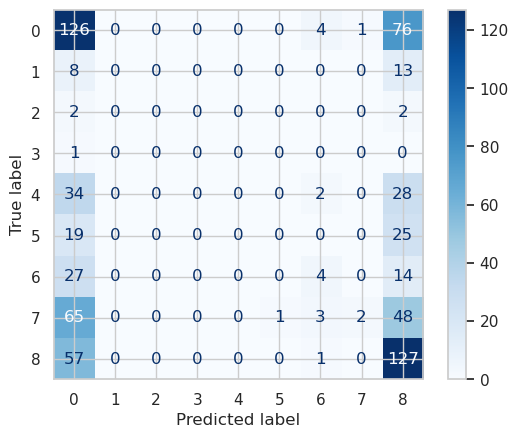

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch  # adjust if your batch is structured differently
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()

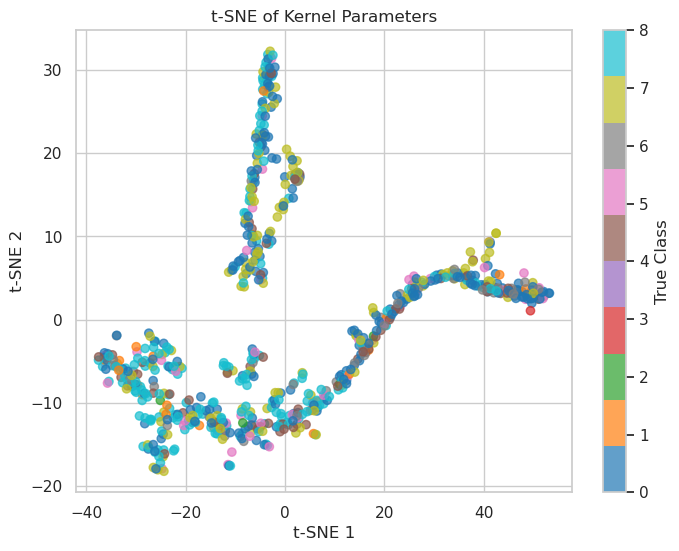

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# Collect all features (X) and labels (y) from the test set
all_features = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        mmsi, X, y = batch
        all_features.append(X.cpu())
        all_labels.extend(y.cpu().numpy())

# Stack all features into a single array
all_features = torch.cat(all_features, dim=0).numpy()
all_labels = np.array(all_labels)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='True Class')
plt.title('t-SNE of Kernel Parameters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## Kernel Fix

Let's add a quick fix for the StateSpaceKernel initialization error:

In [ ]:
# Fix the initialization issue in StateSpaceKernel
# This ensures the cache_lock is created before _setup_system_matrices is called

def fix_state_space_kernel():
    # Get the original __init__ method
    original_init = StateSpaceKernel.__init__
    
    # Define a new __init__ method that creates cache_lock first
    def new_init(self, timesteps, m=1E5, I=1E3, q=1.0, r=1.0, dt=1.0):
        # Initialize cache lock before calling the rest of initialization
        self.cache_lock = threading.Lock()
        
        # Call the original __init__
        original_init(self, timesteps, m, I, q, r, dt)
    
    # Replace the __init__ method
    StateSpaceKernel.__init__ = new_init
    
    print("StateSpaceKernel initialization fixed!")

# Apply the fix
import threading
fix_state_space_kernel()

StateSpaceKernel initialization fixed!


## Fix the State Space Kernel Class

Let's fix the kernel initialization issue by directly updating the source file:

In [ ]:
# Fix the StateSpaceKernel class by updating the source file
import os

kernel_file_path = '/home/daniel/raytheon-ais-analysis/state_space_kernel.py'
with open(kernel_file_path, 'r') as f:
    lines = f.readlines()

# Find the __init__ method and add cache_lock initialization
init_found = False
modified_lines = []
for line in lines:
    if 'def __init__(self, timesteps, m=1E5, I=1E3, q=1.0, r=1.0, dt=1.0):' in line:
        init_found = True
        modified_lines.append(line)
    elif init_found and 'super(StateSpaceKernel, self).__init__()' in line:
        # Add cache_lock initialization right after super().__init__()
        modified_lines.append(line)
        modified_lines.append('        # Create thread lock for cache updates\n')
        modified_lines.append('        self.cache_lock = threading.Lock()\n')
        init_found = False  # Reset flag after modification
    else:
        modified_lines.append(line)

# Make sure threading is imported
if 'import threading' not in ''.join(lines):
    # Find the imports section and add threading import
    for i, line in enumerate(modified_lines):
        if line.startswith('import ') and i > 0:
            modified_lines.insert(i, 'import threading\n')
            break

# Write the modified content back to the file
with open(kernel_file_path, 'w') as f:
    f.writelines(modified_lines)

print(f"Updated {kernel_file_path} to fix the cache_lock initialization.")

# Reload the module to apply changes
import importlib
import state_space_kernel
importlib.reload(state_space_kernel)
from state_space_kernel import StateSpaceKernel

print("StateSpaceKernel module reloaded successfully.")

Updated /home/daniel/raytheon-ais-analysis/state_space_kernel.py to fix the cache_lock initialization.
StateSpaceKernel module reloaded successfully.
